# **Chapter 4: Advanced EEG Analysis**

***

In this section on advanced EEG analysis, , it is divided into the following 4 parts:

- **Part 1: Batch Processing for Reading and Storing Demo Data**
- **Part 2: Classification-based Decoding**  
- **Part 3: Representational Similarity Analysis**
- **Part 4: Inverted Encoding Model**

## Download and Import Python packages we will use

In [1]:
! pip install inverted_encoding

import numpy as np
import sys
import os
from six.moves import urllib
import gdown
import zipfile
import scipy.io as sio
from scipy.stats import ttest_ind
import h5py
from tqdm import tqdm
from neurora.decoding import tbyt_decoding_kfold, ct_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc, plot_ct_decoding_acc, plot_rdm, plot_tbytsim_withstats
from neurora.rdm_cal import eegRDM
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.stuff import smooth_1d
from inverted_encoding import IEM, permutation, circ_diff
from decimal import Decimal
import matplotlib.pyplot as plt

# Part 1 Batch Processing for Reading and Storing Demo Data

### **Preprocessed Demo Data 2**：  
（You will use it in Part 2, Part 3, and Part 4）  
The original dataset is based on the data from Experiment 2 in the article "Dissociable Decoding of Spatial Attention and Working Memory from EEG Oscillations and Sustained Potentials" by Bae & Luck, published in the Journal of Neuroscience in 2019. This involves a visual working memory task where participants were required to remember the orientation of a teardrop shape presented for 200 ms. After a delay of 1300 milliseconds, a teardrop shape with a random orientation was presented, and participants needed to rotate the mouse to match the orientation as closely as possible to the remembered orientation. The stimulus could appear in 16 different orientations and 16 different locations. Here, only data from the first 5 participants are extracted, consisting of preprocessed ERP data (see the original article for preprocessing parameters) with labels for each trial's orientation and location.

In [2]:
# Download Demo Data 2

data_dir = "data/"
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

url = "https://drive.google.com/file/d/1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj/view?usp=sharing"
filename = "demo_data2"
filepath = data_dir + filename + ".zip"

# Download the data
gdown.download(url=url, output=filepath, quiet=False, fuzzy=True)
print("Download completes!")
# unzip the data
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

Downloading...
From (original): https://drive.google.com/uc?id=1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj
From (redirected): https://drive.google.com/uc?id=1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj&confirm=t&uuid=430b6aca-81e1-44b5-a6f4-a2daf145dc2c
To: /Users/zitonglu/Downloads/Python-EEG-Handbook-master/data/demo_data2.zip
100%|████████████████████████████████████████| 301M/301M [00:57<00:00, 5.27MB/s]


Download completes!
Unzip completes!


In the 'data' folder, there are .mat files with EEG data for 5 participants, and in the 'labels' folder, there are files for each participant containing labels for the orientation and location of the stimulus items for all trials. For example, for participant number '201', the file 'ori_201.txt' contains the orientation information for each trial's memory item, and 'pos_201.txt' contains the location information for each trial's memory item. The data includes 27 electrodes, with a sampling rate of 250Hz, covering from 1.5 seconds before to 1.5 seconds after the stimulus presentation, and each trial includes 750 time points.

### Batch Processing to Read Demo Data 2 and Save as a .h5 File

In [3]:
# Five subjects' ids
sub_ids = ['201', '202', '203', '204', '205']

# Iterate over the data of 5 subjects
for i, sub in enumerate(sub_ids):
    
    # The file paths for each participant's ERP data，
    # memory item orientation labels,
    # and memory item position labels
    subdata_path = 'data/demo_data2/data/ERP' + sub + '.mat'
    suborilabels_path = 'data/demo_data2/labels/ori_' + sub + '.txt'
    subposlabels_path = 'data/demo_data2/labels/pos_' + sub + '.txt'
    
    # Read ERP data
    subdata = sio.loadmat(subdata_path)['filtData']
    # Read orientation and position labels
    # In the .txt files, the first column represents the specific orientation/location values,
    # and the second column represents the label values corresponding to the 16 orientations/locations
    # (represented by integers from 0 to 15).
    suborilabels = np.loadtxt(suborilabels_path)[:, 1]
    subposlabels = np.loadtxt(subposlabels_path)[:, 1]
    
    # Print subj id, the shape of ERP data matrix, the shape of two label matrices
    print('sub' + sub)
    print(subdata.shape)
    print(suborilabels.shape)
    print(subposlabels.shape)
    
    # Store the EEG data and label data (in matrix form) of each subject
    # in an .h5 file with 'data', 'orilabels' and 'postlabels' as Keys
    f = h5py.File('data/demo_data2/sub' + sub + '.h5', 'w')
    f.create_dataset('data', data=subdata)
    f.create_dataset('orilabels', data=suborilabels)
    f.create_dataset('poslabels', data=subposlabels)
    f.close()

sub201
(640, 27, 750)
(640,)
(640,)
sub202
(640, 27, 750)
(640,)
(640,)
sub203
(640, 27, 750)
(640,)
(640,)
sub204
(640, 27, 750)
(640,)
(640,)
sub205
(640, 27, 750)
(640,)
(640,)


# Part 2 Classification-based Decoding

### Get EEG Data and Labels

In [4]:
subs = ["201", "202", "203", "204", "205"]

# Initialize data、label_ori, and label_pos to save EEG data and labels
data = np.zeros([5, 640, 27, 500])
label_ori = np.zeros([5, 640])
label_pos = np.zeros([5, 640])

for i, sub in enumerate(subs):

    # Read the .h5 file for each subject
    subfile = h5py.File('data/demo_data2/sub' + sub + '.h5', 'r')
    
    # Get EEG data
    subdata = subfile['data']
    
    # Shape of subdata: [640, 27, 750]
    # 640 - N_trials； 27 - N_channels； 750 - N_timepoints（from -1.5s to 1.5s）

    # Only use the EEG data from -0.5s to 1.5s
    subdata = subdata[:, :, 250:]
    
    # Get orientation labels
    sublabel_ori = subfile['orilabels']
    # Get position labels
    sublabel_pos = subfile['poslabels']
    
    data[i] = subdata
    label_ori[i] = sublabel_ori
    label_pos[i] = sublabel_pos

### Time-by-Time EEG Decoding

#### Time-by-time decoding for orientation information

In [5]:
# Here, we use the tbyt_decoding_kfold() function from the decoding module of NeuroRA
# to perform decoding at each time point. We input the data (with shape [n_subs, n_trials, n_channels, n_times]),
# labels corresponding to each trial, and several other parameters, including:
# - 'n=16' - The number of classification categories is 16 (representing 16 orientations)
# - 'navg=13' - Averaging across 13 trials at a time
# - 'time_win=5' - The time window is 5 (i.e., data from 5 time points are averaged together)
# - 'time_step=5' - The time step is 5 (i.e., decoding is performed at every interval of 5 time points)
# - 'nfolds=3' & 'nrepeats=10' - Conducting 10 repetitions of 3-fold cross-validation
# - 'smooth=True' - Applying smoothing to the results
accs_ori = tbyt_decoding_kfold(data, label_ori, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### Plot time-by-time orientation decoding results


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
200ms to 520ms
679ms to 800ms


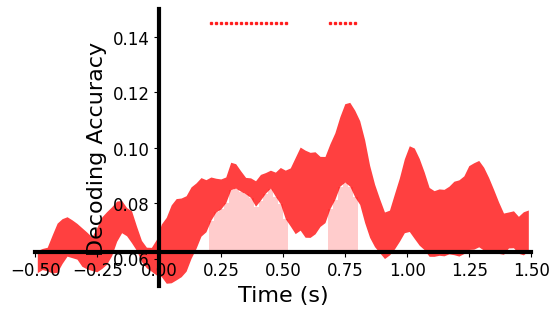

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
# Here, we use the plot_tbyt_decoding_acc() function from the decoding module of NeuroRA
# for statistical analysis and visualization.
# It requires the input of decoding results (shape as [n_subs, n_results_times]) and several other parameters:
# - 'start_time=-0.5' - The start time of the decoding results is -0.5s,
# - 'end_time=1.5' - The end time of the decoding results is 1.5s,
# - 'time_interval=0.02' - The interval between two decoding times is 0.02s
#   (since the time window is 5, and the original sampling rate is 250Hz, 5*(1/250)=0.02s),
# - 'chance=0.0625' - The chance level of classification accuracy is 0.0625 (16 orientations, i.e., 1/16),
# - 'p=0.05' - The threshold for p-value,
# - 'cbpt=True' - Conducting cluster-based permutation test,
# - 'stats_time=[0, 1.5]' - Analyzing decoding results from 0 to 1.5s,
# - 'xlim=[-0.5, 1.5]' - The display range of the x-axis from -0.5 to 1.5,
# - 'ylim=[0.05, 0.15]' - The display range of the y-axis from 0.05 to 0.15.
plot_tbyt_decoding_acc(accs_ori, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

#### Time-by-time decoding for position information

In [7]:
accs_pos = tbyt_decoding_kfold(data, label_pos, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### Plot time-by-time position decoding results


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
79ms to 459ms
600ms to 740ms
919ms to 1200ms
1220ms to 1320ms


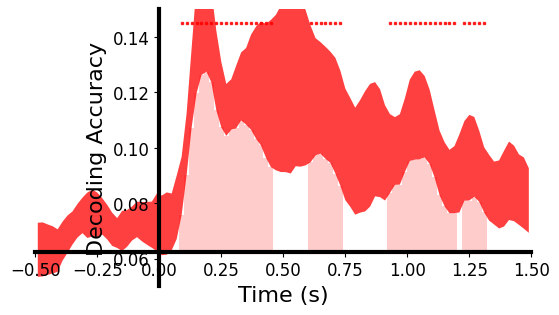

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
plot_tbyt_decoding_acc(accs_pos, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

### Cross-Temporal EEG Decoding

#### Cross-temporal decoding for orientation and position information

for orientation

In [9]:
# Here, we use the ct_decoding_kfold() function from the decoding module of NeuroRA
accs_crosstime_ori = ct_decoding_kfold(data, label_ori, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!



for position

In [10]:
accs_crosstime_pos = ct_decoding_kfold(data, label_pos, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### Plot cross-temporal orientation and position decoding results

for orientation


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



/Users/zitonglu/anaconda3/lib/python3.11/site-packages/neurora/rsa_plot.py:1050: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, np.transpose(newps, (1, 0)), [0, 1], colors="silver", alpha=0.9, linewidths=3,


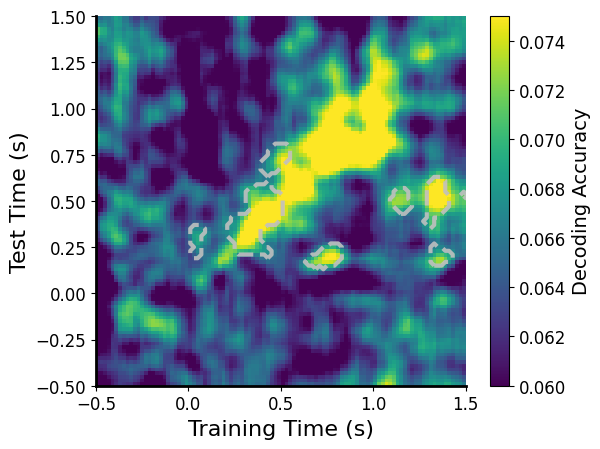

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
# Here, we use the plot_ct_decoding_acc() function from the decoding module of NeuroRA
plot_ct_decoding_acc(accs_crosstime_ori, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

for position


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



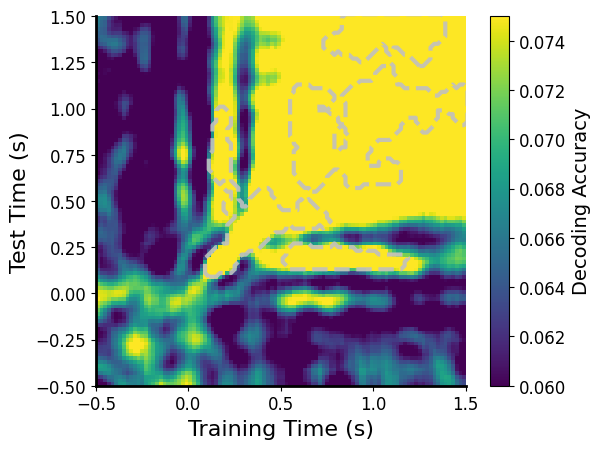

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
plot_ct_decoding_acc(accs_crosstime_pos, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

# Part 3 Representational Similarity Analysis

### Calculate EEG Representational Dissimilarity Matrices (RDMs)

Based on the 16 orientations and 16 locations, calculate the EEG RDM representing orientation information and the EEG RDM representing position information at each time point, respectively, for a 16×16 matrix.

In [13]:
n_subs = 5
n_trials = 640
# Obtain EEG data under 16 orientation conditions and 16 position conditions, respectively
# Initialize data_ori and data_pos to store data for orientation and position, respectively
data_ori = np.zeros([16, n_subs, 40, 27, 500])
data_pos = np.zeros([16, n_subs, 40, 27, 500])
for sub in range(n_subs):
    index_ori = np.zeros([16], dtype=int)
    index_pos = np.zeros([16], dtype=int)
    for i in range(n_trials):
        ori = int(label_ori[sub, i])
        pos = int(label_pos[sub, i])
        data_ori[ori, sub, index_ori[ori]] = data[sub, i]
        index_ori[ori] = index_ori[ori] + 1
        data_pos[pos, sub, index_pos[pos]] = data[sub, i]
        index_pos[pos] = index_pos[pos] + 1
        
# Calculate EEG RDMs using eegRDM() function from the rdm_cal module in NeuroRA
# Orientation RDMs
RDMs_ori = eegRDM(data_ori, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# Position RDMs
RDMs_pos = eegRDM(data_pos, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# The shapes of the returned RDMs_ori and RDMs_pos are both [N_subs, N_results_time, 16, 16] ([5, 100, 16, 16]).


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!

Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!


### Construct the Hypothesis-based RDM

The hypothesis-based RDM is based on the hypothesis that the closer two angles are, the higher their similarity, and the more distant two angles are, the lower their similarity.  
Here, the RDM below is applicable to both orientation and position information in our example.

1


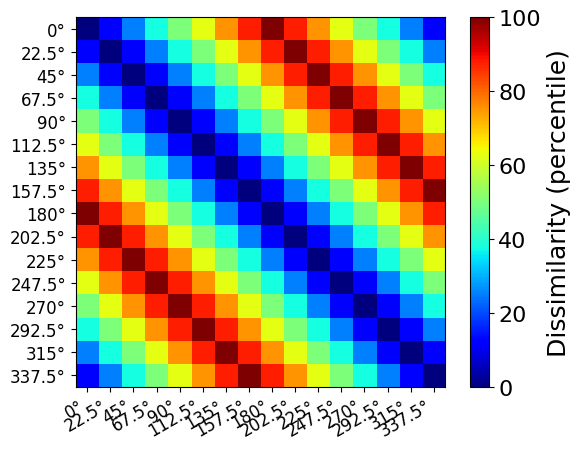

0

In [14]:
model_RDM = np.zeros([16, 16])
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            model_RDM[i, j] = diff / 8
        else:
            model_RDM[i, j] = (16 - diff) / 8

# Visualize the RDM using plot_rdm() function from the rsa_plot module in NeuroRA
conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]
plot_rdm(model_RDM, percentile=True, conditions=conditions)

### RSA

Calculate the similarity between the hypothesis-based RDM and the orientation EEG RDMs, as well as the position EEG RDMs, to temporally track when the brain conforms to the encoding of orientation and when it conforms to the encoding of position.

In [15]:
# Use the rdms_corr() function from the corr_cal_by_rdm module in NeuroRA
# Calculate the similarity between the hyp RDM and ori EEG RDMs
similarities_ori = rdms_corr(model_RDM, RDMs_ori)
# Calculate the similarity between the hyp RDM and posi EEG RDMs
similarities_pos = rdms_corr(model_RDM, RDMs_pos)


Computing similarities

Computing finished!

Computing similarities

Computing finished!


Plot the RSA results of orientation information


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
219ms to 360ms
380ms to 620ms
640ms to 880ms


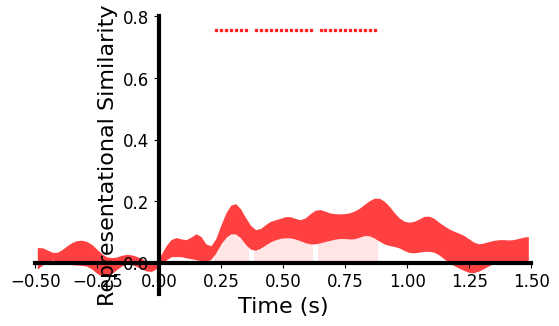

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
# Here, we use plot_tbytsim_withstats() function from the rsa_plot module in NeuroRA
# Similar to plot_tbyt_decoding_acc()

plot_tbytsim_withstats(similarities_ori, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

Plot the RSA results of position information


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
40ms to 1020ms


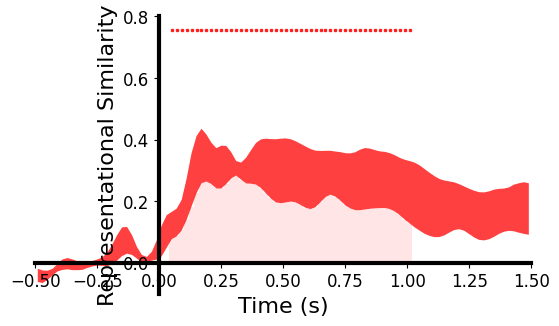

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
plot_tbytsim_withstats(similarities_pos, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

# Part 4 Inverted Encoding Model

In this part, we refer to a preprint "Scotti, P. S., Chen, J., & Golomb, J. D. (2021). An enhanced inverted encoding model for neural reconstructions. bioRxiv" that utilized enhanced inverted encoding model (eIEM).

#### Apply eIEM to decode orientation information

In [18]:
n_subs = 5
n_ts = 100

# Initialize mae_ori to save MAE results from IEM decoding
mae_ori = np.zeros([n_subs, n_ts])

# Calculate the MAE for each timepoint and subject using IEM function in Inverted_Encoding
for t in tqdm(range(n_ts)):
    for sub in range(n_subs):
        
        # Downsampling the data - average the data for every 5 timepoints
        data_t_sub = np.average(data[sub, :, :, t*5:t*5+5], axis=2)
        
        # Get IEM predictions
        predictions, _, _, _ = IEM(data_t_sub, label_ori[sub].astype(int), stim_max=16, nfolds=5, is_circular=True)
        
        # Calculate MAE
        mae_ori[sub, t] = np.mean(np.abs(circ_diff(predictions, label_ori[sub].astype(int), 16)))

# Use permutation() function in Inverted_Encoding to get null distribution of MAE
null_mae_ori = permutation(label_ori[sub].astype(int), stim_max=16, num_perm=5000, is_circular=True)

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


#### Define a function to plot eIEM results - plot_iem_results()

For the visualization, we calculate the $\Delta$MAE (the mean of null mae minus mae) as the final IEM results.

In [19]:
def plot_iem_results(mae_ori, null_mae, start_time=0, end_time=1, time_interval=0.01,
                     stats_time=[0, 1], xlim=[0, 1], ylim=[-0.1, 0.8]):

    """
    Plot the time-by-time eIEM results

    Parameters
    ----------
    mae : array
        The mae results.
    null_mae : array
        The null distribution of mae.
    start_time : int or float. Default is 0.
        The start time.
    end_time : int or float. Default is 1.
        The end time.
    time_interval : float. Default is 0.01.
        The time interval between two time samples.
    xlim : array or list [xmin, xmax]. Default is [0, 1].
        The x-axis (time) view lims.
    ylim : array or list [ymin, ymax]. Default is [0.4, 0.8].
        The y-axis (decoding accuracy) view lims.
    """

    if len(np.shape(mae_ori)) != 2:

        return "Invalid input!"

    n = len(np.shape(mae_ori))

    yminlim = ylim[0]
    ymaxlim = ylim[1]

    nsubs, nts = np.shape(mae_ori)
    tstep = float(Decimal((end_time - start_time) / nts).quantize(Decimal(str(time_interval))))

    if tstep != time_interval:
        return "Invalid input!"

    delta1 = (stats_time[0] - start_time) / tstep - int((stats_time[0] - start_time) / tstep)
    delta2 = (stats_time[1] - start_time) / tstep - int((stats_time[1] - start_time) / tstep)

    mae_ori = smooth_1d(mae_ori)

    avg = np.average(np.average(null_mae)-mae_ori, axis=0)
    err = np.zeros([nts])

    for t in range(nts):
        err[t] = np.std(mae_ori[:, t], ddof=1)/np.sqrt(nsubs)

    ps = np.zeros([nts])
    for t in range(nts):
        ps[t] = ttest_ind(mae_ori[:, t], null_mae, alternative='less')[1]
        if ps[t] < 0.05:
            ps[t] = 1
        else:
            ps[t] = 0

    print('\nSignificant time-windows:')
    for t in range(nts):
        if t == 0 and ps[t] == 1:
            print(str(int(start_time * 1000)) + 'ms to ', end='')
        if t > 0 and ps[t] == 1 and ps[t - 1] == 0:
            print(str(int((start_time + t * tstep) * 1000)) + 'ms to ', end='')
        if t < nts - 1 and ps[t] == 1 and ps[t + 1] == 0:
            print(str(int((start_time + (t + 1) * tstep) * 1000)) + 'ms')
        if t == nts - 1 and ps[t] == 1:
            print(str(int(end_time * 1000)) + 'ms')

    for t in range(nts):
        if ps[t] == 1:
            plt.plot(t*tstep+start_time+0.5*tstep, (ymaxlim-yminlim)*0.95+yminlim, 's',
                     color='r', alpha=0.8, markersize=2)
            xi = [t*tstep+start_time, t*tstep+tstep+start_time]
            ymin = [0]
            ymax = [avg[t]-err[t]]
            plt.fill_between(xi, ymax, ymin, facecolor='r', alpha=0.1)

    fig = plt.gcf()
    fig.set_size_inches(6.4, 3.6)

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))
    x = np.arange(start_time+0.5*tstep, end_time+0.5*tstep, tstep)
    plt.plot(x, avg, color='r', alpha=0.95)
    plt.fill_between(x, avg + err, avg - err, facecolor='r', alpha=0.75)
    plt.ylim(yminlim, ymaxlim)
    plt.xlim(xlim[0], xlim[1])
    plt.tick_params(labelsize=12)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(r'$\Delta$MAE', fontsize=16)
    
    plt.show()

    return ps

Plot the IEM results of orientation information


Significant time-windows:
219ms to 1440ms


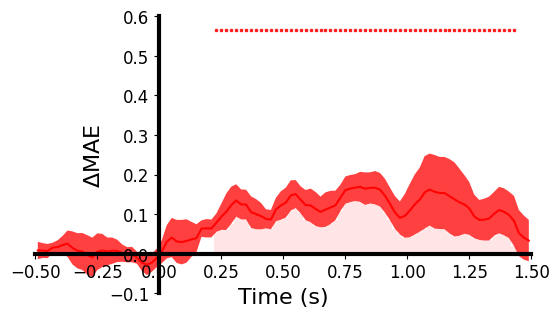

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [20]:
plot_iem_results(mae_ori, null_mae_ori, start_time=-0.5, end_time=1.5, time_interval=0.02,
                 xlim=[-0.5, 1.5], ylim=[-0.1, 0.6])

#### Apply eIEM to decode position information

In [21]:
# Initialize mae_pos to save MAE results from IEM decoding
mae_pos = np.zeros([n_subs, n_ts])

# Calculate the MAE for each timepoint and subject using IEM function in Inverted_Encoding
for t in tqdm(range(n_ts)):
    for sub in range(n_subs):
        
        # Downsampling the data - average the data for every 5 timepoints
        data_t_sub = np.average(data[sub, :, :, t*5:t*5+5], axis=2)
        
        # Get IEM predictions
        predictions, _, _, _ = IEM(data_t_sub, label_pos[sub].astype(int), stim_max=16, nfolds=5, is_circular=True)
        
        # Calculate MAE
        mae_pos[sub, t] = np.mean(np.abs(circ_diff(predictions, label_pos[sub].astype(int), 16)))

# Use permutation() function in Inverted_Encoding to get null distribution of MAE
null_mae_pos = permutation(label_pos[sub].astype(int), stim_max=16, num_perm=5000, is_circular=True)

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Plot the IEM results of position information


Significant time-windows:
0ms to 1500ms


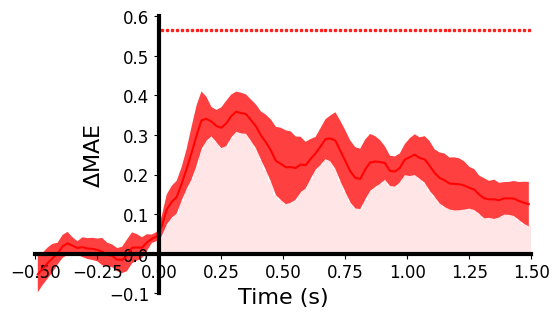

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
plot_iem_results(mae_pos, null_mae_pos, start_time=-0.5, end_time=1.5, time_interval=0.02,
                 xlim=[-0.5, 1.5], ylim=[-0.1, 0.6])